In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import requests
import geopandas as gpd
import shapely
from shapely.geometry import Polygon, LineString, MultiPoint, Point
from shapely.ops import nearest_points
from rtree import index
from collections import defaultdict

In [2]:
gdf = gpd.read_file('gz_2010_us_outline_500k.json') # https://eric.clst.org/tech/usgeojson/

<Axes: >

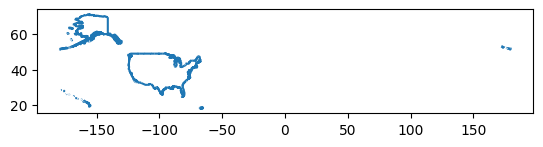

In [3]:
gdf.plot()

<Axes: >

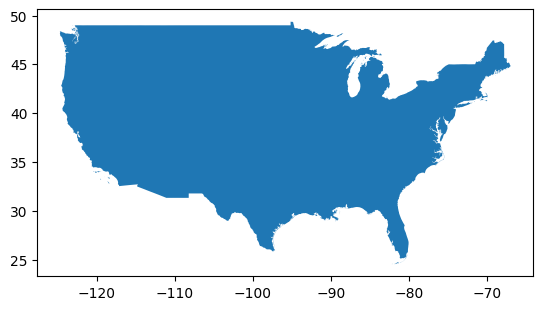

In [4]:
x1 = gdf.geometry.apply(lambda geom: geom.coords[0][0])
y1 = gdf.geometry.apply(lambda geom: geom.coords[0][1])
x2 = gdf.geometry.apply(lambda geom: geom.coords[1][0])
y2 = gdf.geometry.apply(lambda geom: geom.coords[1][1])

in_range = ((-130 < x1) & (x1 < -50)) & ((24 < y1) & (y1 < 50))
mainland = gdf[in_range]
us_area = mainland.build_area()
us_area.plot()

<Axes: >

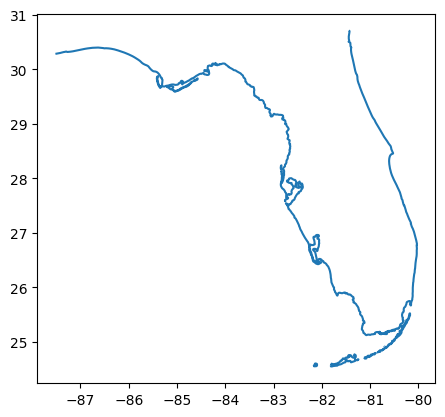

In [5]:
x1 = mainland.geometry.apply(lambda geom: geom.coords[0][0])
y1 = mainland.geometry.apply(lambda geom: geom.coords[0][1])
x2 = mainland.geometry.apply(lambda geom: geom.coords[1][0])
y2 = mainland.geometry.apply(lambda geom: geom.coords[1][1])

in_range = ((-87.4 < x1) & (x1 < -79)) & ((24 < y1) & (y1 < 30.71))
florida_coast = mainland[in_range]
florida_coast.plot()

In [ ]:
def get_storm_id1(df):
    rows = df['rows'].to_numpy()
    N = len(rows)
    ans = np.zeros(N,dtype=int)
    for i in range(len(rows)):
        to_add = rows[i] + 1
        ans = ans + np.concatenate((np.zeros(i,dtype=int),np.full(N-i,to_add,dtype=int)))
    return ans

def get_storm_id2(df):
    rows = df['rows'].to_numpy() + 1
    return [df['storm_id'].iloc[i]*rows[i] for i in range(len(df))]

get_storm_id2(dfh)

In [99]:
url = "https://www.nhc.noaa.gov/data/hurdat/hurdat2-1851-2024-040425.txt"
text = requests.get(url).text
lines = pd.Series(text.split('\n')[:-1]).str.replace(' ','')
is_header = lines.str.startswith('AL')

linedf = pd.DataFrame({'raw_line':lines,'is_header':is_header})
linedf['storm_id'] = np.where(linedf['is_header'],linedf['raw_line'].str.split(',').str[0],np.nan)
linedf['storm_id']=linedf['storm_id'].ffill()

dfh = lines[is_header].str.split(',',n=2,expand = True)
dfh = dfh.rename(columns={0: 'storm_id', 1: 'storm_name',2:'rows'})
dfh['rows'] = pd.to_numeric(dfh['rows'].str.replace(',',''))
dfh=dfh.set_index('storm_id',drop=True)

dfm = linedf[is_header == False]
dfm = pd.concat([dfm,dfm['raw_line'].str.split(',',expand = True)],axis=1)
dfm = dfm.rename(columns={
    0: 'date', 1: 'hours', 2:'landfall_marker', 3:'status', 4:'latitude_N', 5:'longitude_E_old', 6:'wind_speed', 7: 'pressure'
})
dfm = dfm.drop(range(8,21),axis=1)
cols_to_convert = ['wind_speed','pressure']
dfm[cols_to_convert] = dfm[cols_to_convert].apply(pd.to_numeric, errors='coerce')
dfm['datetime'] = pd.to_datetime(
    dfm['date'] + dfm['hours'],
    format='%Y%m%d%H%M'
)
dfm['latitude_N'] = pd.to_numeric(dfm['latitude_N'].str[:-1])
dfm['longitude_E'] = pd.to_numeric(dfm['longitude_E_old'].str[:-1])
dfm['longitude_E'] = np.where(dfm['longitude_E_old'].str[-1] == 'E',dfm['longitude_E'],dfm['longitude_E']*-1)
dfm = dfm.drop(['longitude_E_old','raw_line'],axis=1)
dfm = gpd.GeoDataFrame(dfm,geometry = gpd.points_from_xy(dfm['longitude_E'], dfm['latitude_N']),crs = us_area.crs)
dfm['on_land'] = dfm.within(us_area.unary_union)

C:\Users\benjr\AppData\Local\Temp\ipykernel_16240\3320941363.py:32: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  dfm['on_land'] = dfm.within(us_area.unary_union)


In [80]:
dfh

,storm_name,rows,made_landfall_in_florida
storm_id,,,
AL011851,UNNAMED,14,False
AL021851,UNNAMED,1,False
AL031851,UNNAMED,1,False
AL041851,UNNAMED,49,True
AL051851,UNNAMED,16,False
...,...,...,...
AL152024,NADINE,8,False
AL162024,OSCAR,17,False
AL172024,PATTY,15,False


C:\Users\benjr\AppData\Local\Temp\ipykernel_16240\3090254393.py:13: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dfl = dfm.groupby(by='storm_id').apply(create_lines).reset_index()
C:\Users\benjr\AppData\Local\Temp\ipykernel_16240\3090254393.py:14: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  dfl['crosses'] = dfl.crosses(florida_coast.unary_union)


<Axes: >

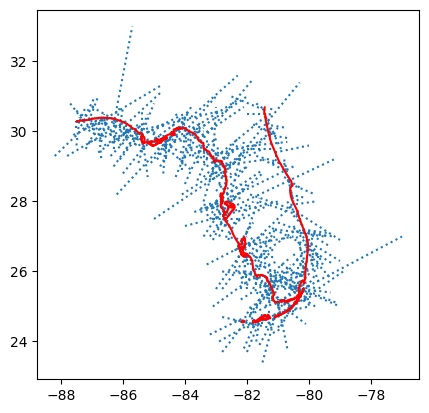

In [101]:
def create_lines(prev_df):

    df = prev_df[['geometry','on_land','datetime','wind_speed']].copy()
    df=df.rename(columns={'on_land': 'starts_on_land'})
    
    df['shifted_geo'] = df['geometry'].shift(-1)
    # Drop the first row which will have a NaN for the previous point
    df = df.iloc[:-1]
    new_lines_list = [LineString([start, end]) for start, end in zip(df['geometry'], df['shifted_geo'])]
    df = df.drop(columns=['shifted_geo','geometry'])
    return gpd.GeoDataFrame(df, geometry = new_lines_list).reset_index(drop=True)

dfl = dfm.groupby(by='storm_id').apply(create_lines).reset_index()
dfl['crosses'] = dfl.crosses(florida_coast.unary_union)
dfl['landfall'] = (dfl['starts_on_land'] == False) & dfl['crosses']

fig,ax=plt.subplots()
dfl[dfl['landfall']].plot(linestyle='dotted',ax=ax)
florida_coast.plot(color='red',ax=ax)

In [108]:
def analyze_storm(df_in):
    df = df_in[df_in['landfall'] ==True][['datetime','geometry','storm_id','wind_speed']].copy()
    df.rename(columns={'wind_speed':'wind_speed_at_first_landfall'})
    df['max_wind_speed'] = df['wind_speed'].max()
    return df.loc[df['datetime'] == df['datetime'].min()]

landfall_events = dfl.groupby(by='storm_id').apply(analyze_storm).set_index('storm_id',drop = True)
valid_hurricane_df = pd.concat([dfh,landfall_events],join = 'inner',axis=1)

C:\Users\benjr\AppData\Local\Temp\ipykernel_16240\1788631880.py:7: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  landfall_events = dfl.groupby(by='storm_id').apply(analyze_storm).set_index('storm_id',drop = True)


In [109]:
valid_hurricane_df

,storm_name,rows,datetime,geometry,wind_speed,max_wind_speed,datetime,geometry,wind_speed,max_wind_speed
storm_id,,,,,,,,,,
AL041851,UNNAMED,49,1851-08-23 18:00:00,"LINESTRING (-86.1 29.6, -85.7 30.1)",100.0,100.0,1851-08-23 18:00:00,"LINESTRING (-86.1 29.6, -85.7 30.1)",100,100.0
AL031852,UNNAMED,20,1852-09-11 18:00:00,"LINESTRING (-83.4 27.9, -82.8 28)",70.0,70.0,1852-09-11 18:00:00,"LINESTRING (-83.4 27.9, -82.8 28)",70,70.0
AL051852,UNNAMED,25,1852-10-09 18:00:00,"LINESTRING (-84.9 29.2, -84.4 29.9)",90.0,90.0,1852-10-09 18:00:00,"LINESTRING (-84.9 29.2, -84.4 29.9)",90,90.0
AL051856,UNNAMED,40,1856-08-31 06:00:00,"LINESTRING (-85.9 30.2, -84.8 31.1)",90.0,90.0,1856-08-31 06:00:00,"LINESTRING (-85.9 30.2, -84.8 31.1)",90,90.0
AL031858,UNNAMED,16,1858-09-14 12:00:00,"LINESTRING (-83.1 26.9, -82.7 27.6)",60.0,60.0,1858-09-14 12:00:00,"LINESTRING (-83.1 26.9, -82.7 27.6)",60,60.0
...,...,...,...,...,...,...,...,...,...,...
AL172022,NICOLE,26,2022-11-10 07:45:00,"LINESTRING (-80.3 27.6, -81.6 28)",65.0,65.0,2022-11-10 07:45:00,"LINESTRING (-80.3 27.6, -81.6 28)",65,65.0
AL102023,IDALIA,54,2023-08-30 09:00:00,"LINESTRING (-84.1 29.1, -83.6 29.9)",115.0,115.0,2023-08-30 09:00:00,"LINESTRING (-84.1 29.1, -83.6 29.9)",115,115.0
AL042024,DEBBY,35,2024-08-05 11:00:00,"LINESTRING (-83.5 29.7, -83.4 29.9)",70.0,70.0,2024-08-05 11:00:00,"LINESTRING (-83.5 29.7, -83.4 29.9)",70,70.0


In [ ]:
landfall_storms = dfl.loc[dfl['landfall'], 'storm_id'].unique()
made_landfall_series = dfh.index.isin(landfall_storms)

dfh['made_landfall_in_florida'] = made_landfall_series
dfl

<Axes: xlabel='length', ylabel='Count'>

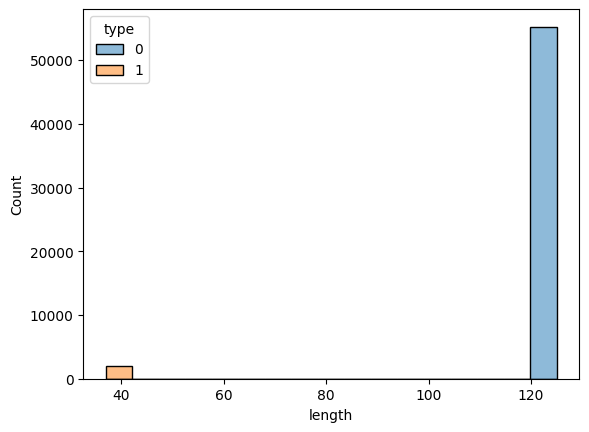

In [110]:
url = "https://www.nhc.noaa.gov/data/hurdat/hurdat2-1851-2024-040425.txt"
text = requests.get(url).text
lines = text.split('\n')[:-1]

def is_header_line(line):
    if(len(line)<2):
        print("ERROR")
    else:
        if(line[:2].isnumeric()):
            return 0
        else:
            return 1

data = [[is_header_line(line),len(line)] for line in lines]
data = np.array(data).T

df = pd.DataFrame()
df['type'] = pd.Series(data[0])
df['length'] = pd.Series(data[1])
sns.histplot(df,x = 'length', hue = 'type')

In [111]:
def process_header(line):
    part1,part2,part3,empty = line.split(',')

    return {
        'storm_id': part1,
        'basin': part1[:2],
        'cyc_num_year': int(part1[2:4]),
        'year': int(part1[4:8]),
        'name': part2.replace(' ',''),
        'rows': int(part3)
    }

def process_motion(line):
    spaces = line.split(',')
    info = {
        'year': int(spaces[0][:4]),
        'month': int(spaces[0][4:6]),
        'day': int(spaces[0][6:8]),
        'hours':  int(spaces[1][1:3]),
        'minutes': int(spaces[1][3:5]),
        'extra_marker': spaces[2].replace(' ',''),
        'status': spaces[3].replace(' ',''),
        'latitude_N': float(spaces[4][:-1]),
        'longitude_E': float(spaces[5][:-1]) * (-1 if spaces[5][-1] == 'W' else -1),
        'max_wind': float(spaces[6]),
        'max_pressure': float(spaces[7]),
        '34kt': [float(space) for space in spaces[8:12]],
        '50kt': [float(space) for space in spaces[12:16]],
        '64kt': [float(space) for space in spaces[16:20]]
    }
    info['shapely_point'] = Point(info['longitude_E'],info['latitude_N'])
    return info

process_motion(lines[1])

{'year': 1851,
 'month': 6,
 'day': 25,
 'hours': 0,
 'minutes': 0,
 'extra_marker': '',
 'status': 'HU',
 'latitude_N': 28.0,
 'longitude_E': -94.8,
 'max_wind': 80.0,
 'max_pressure': -999.0,
 '34kt': [-999.0, -999.0, -999.0, -999.0],
 '50kt': [-999.0, -999.0, -999.0, -999.0],
 '64kt': [-999.0, -999.0, -999.0, -999.0],
 'shapely_point': <POINT (-94.8 28)>}

In [126]:
datah = []
datam = []
datal = []
datals = []
current_storm = ''
new_storm = False
last_point = None
i=0
for line in lines:
    if(is_header_line(line)):
        dp = process_header(line)
        current_storm = dp['storm_id']
        datah.append(dp)
        new_storm = True
        i=0
    else:
        dp = process_motion(line)
        dp['storm_id'] = current_storm
        dp['record_no'] = i
        i=i+1
        datam.append(dp)
        if not new_storm:
            datal.append(LineString([(last_point['longitude_E'],last_point['latitude_N']), (dp['longitude_E'], dp['latitude_N'])]))
            datals.append(current_storm)
        last_point = dp
        new_storm = False


dfh = pd.DataFrame(datah)
#dfh = dfh.set_index('storm_id')
dfm = pd.DataFrame(datam)

hurricane_geometry = gpd.GeoSeries(dfm['shapely_point'])
dfm = gpd.GeoDataFrame(dfm, geometry=hurricane_geometry, crs=us_area.crs)
dfm['on_land'] = dfm.within(us_area.unary_union)

C:\Users\benjr\AppData\Local\Temp\ipykernel_16240\3372553266.py:35: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  dfm['on_land'] = dfm.within(us_area.unary_union)


Text(47.097222222222214, 0.5, 'Latitude')

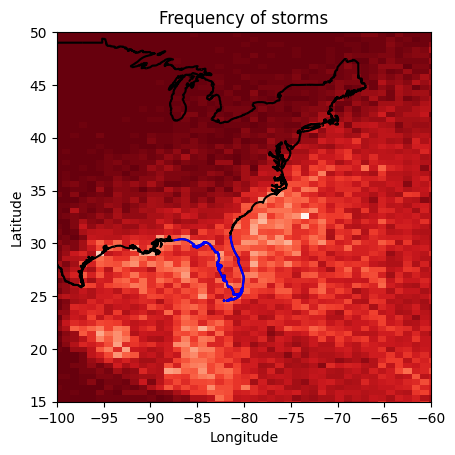

In [127]:
fig,ax = plt.subplots()

plt.hist2d(dfm['longitude_E'], dfm['latitude_N'], bins=(150, 150),cmap = 'Reds_r') 
#plt.tight_layout()
mainland.plot(ax=ax,color='black')
florida_coast.plot(ax=ax,color = 'blue')
ax.set_xlim([-100,-60])
ax.set_ylim([15,50])
ax.set_title('Frequency of storms')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

In [128]:
def create_lines(prev_df):

    df = prev_df[['geometry','on_land']].copy()
    df=df.rename(columns={'on_land': 'starts_on_land'})
    
    df['shifted_geo'] = df['geometry'].shift(-1)
    # Drop the first row which will have a NaN for the previous point
    df = df.iloc[:-1]
    new_lines_list = [LineString([start, end]) for start, end in zip(df['geometry'], df['shifted_geo'])]
    df = df.drop(columns=['shifted_geo','geometry'])
    return gpd.GeoDataFrame(df, geometry = new_lines_list).reset_index(drop=True)

dfl = dfm.groupby(by='storm_id').apply(create_lines).reset_index()

C:\Users\benjr\AppData\Local\Temp\ipykernel_16240\3253475993.py:13: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dfl = dfm.groupby(by='storm_id').apply(create_lines).reset_index()


In [130]:
dfl['crosses'] = dfl.crosses(florida_coast.unary_union)

dfl['landfall'] = (dfl['starts_on_land'] == False) & dfl['crosses']

#dfl[dfl['landfall']].plot()



"""landfall_storms = dfl[dfl['landfall']]['storm_id'].unique()
made_landfall_series = dfh['storm_id'].isin(landfall_storms)

dfh['made_landfall_in_florida'] = made_landfall_series"""

landfall_storms = dfl[dfl['landfall']]['storm_id'].unique()
made_landfall_series = dfh['storm_id'].isin(landfall_storms)
dfh['made_landfall_in_florida'] = made_landfall_series

C:\Users\benjr\AppData\Local\Temp\ipykernel_16240\3827123336.py:1: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  dfl['crosses'] = dfl.crosses(florida_coast.unary_union)


In [133]:
dfh['max_wind']=dfm.groupby(by='storm_id').apply(lambda x: max(x['max_wind']))
dfh['reaches_hurricane']=dfm.groupby(by='storm_id').apply(lambda x: (x['status'] == 'HU').any())

dfh[dfh['made_landfall_in_florida']]

C:\Users\benjr\AppData\Local\Temp\ipykernel_16240\166399413.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dfh['max_wind']=dfm.groupby(by='storm_id').apply(lambda x: max(x['max_wind']))
C:\Users\benjr\AppData\Local\Temp\ipykernel_16240\166399413.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dfh['reaches_hurricane']=dfm.groupby(by='storm_id').apply(lambda x: (x['status'] == 'HU').any())


,storm_id,basin,cyc_num_year,year,name,rows,made_landfall_in_florida,max_wind,reaches_hurricane
3,AL041851,AL,4,1851,UNNAMED,49,True,NaN,NaN
8,AL031852,AL,3,1852,UNNAMED,20,True,NaN,NaN
10,AL051852,AL,5,1852,UNNAMED,25,True,NaN,NaN
33,AL051856,AL,5,1856,UNNAMED,40,True,NaN,NaN
41,AL031858,AL,3,1858,UNNAMED,16,True,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1951,AL172022,AL,17,2022,NICOLE,26,True,NaN,NaN
1961,AL102023,AL,10,2023,IDALIA,54,True,NaN,NaN
1976,AL042024,AL,4,2024,DEBBY,35,True,NaN,NaN
1980,AL092024,AL,9,2024,HELENE,25,True,NaN,NaN


In [ ]:
dfm.loc(dfm['landfall'])

In [ ]:
fig,ax=plt.subplots()

def plot_storm(storm_id,ax):
    line_data = dfl[dfl['storm_id'] == storm_id]
    point_data = dfm[dfm['storm_id'] == storm_id]
    line_data.plot(ax=ax)

    landfall_lines = line_data[line_data['landfall']]
    landfall_lines.plot(ax=ax,color='red')
    
    point_data.plot(ax=ax)
    florida_coast.plot(ax=ax)
    ax.set_title(f'Path of storm {storm_id}')
    ax.set_xlim([-88,-77])
    ax.set_ylim([22,31])
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')



plot_storm('AL041851',ax)